In [4]:
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
from torchvision import models

from tensorboardX import SummaryWriter
writer = SummaryWriter()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [164]:
# MEAN = (0.485, 0.456, 0.406) # Ìï¥Îãπ Îç∞Ïù¥ÌÑ∞Îäî Ï†ïÍ∑úÌôîÏãú ÏÇ¨Ïö©ÎêòÎäî ÌèâÍ∑†Í∞íÏúºÎ°ú, Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïùò ÌèâÍ∑úÍ∞íÏùÑ Íµ¨Ìï¥ÏïºÌï©ÎãàÎã§.
# STD = (0.229, 0.224, 0.225)  # Ìï¥Îãπ Îç∞Ïù¥ÌÑ∞Îäî Ï†ïÍ∑úÌôîÏãú ÏÇ¨Ïö©ÎêòÎäî ÌëúÏ§ÄÌé∏Ï∞®Í∞íÏúºÎ°ú, Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïùò ÌëúÏ§ÄÌé∏Ï∞®Í∞í Íµ¨Ìï¥ÏïºÌï©ÎãàÎã§.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor Î°ú Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏùÑ Î∞îÍøâÎãàÎã§
    transforms.Resize((224, 224)),      # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º Î≥ÄÍ≤ΩÌï©ÎãàÎã§. (Ïù¥Îäî ÏÇ¨Ïö© Î™®Îç∏Ïóê Îî∞Îùº Î≥ÄÍ≤Ω Îê† Ïàò ÏûàÏùå)
    transforms.Grayscale(num_output_channels=3),             # Ïù¥ Ïù¥ÎØ∏ÏßÄÏùò Í≤ΩÏö∞ ÌùëÎ∞±ÏúºÎ°ú Ï≤òÎ¶¨ÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§. Í∑ºÎç∞ RGB Ï±ÑÎÑêÏù¥ ÏûàÏúºÎØÄÎ°ú Ïù¥ Ìï®ÏàòÎ°ú ÌùëÎ∞±ÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    RandomHorizontalFlip(p=0.5),        # Í≥ºÏ†ÅÌï©ÏùÑ ÎßâÍ∏∞ ÏúÑÌï¥ Ïù¥ÎØ∏ÏßÄÎ•º ÎûúÎç§ÏúºÎ°ú Ï¢åÏö∞ ÎåÄÏπ≠ÏùÑ Î≥ÄÌôòÌï©ÎãàÎã§.
    transforms.RandomRotation(degrees=(-15, 15)),   # Í≥ºÏ†ÅÌï©ÏùÑ ÎßâÍ∏∞ ÏúÑÌï¥ Ïù¥ÎØ∏ÏßÄÎ•º Î¨¥ÏûëÏúÑÎ°ú ÌöåÏ†Ñ
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Í≥ºÏ†ÅÌï©ÏùÑ ÎßâÍ∏∞ ÏúÑÌïú Ïù¥ÎØ∏ÏßÄÏùò Î∞ùÍ∏∞ÏôÄ ÎåÄÎπÑÎ•º Î¨¥ÏûëÏúÑÎ°ú Î≥ÄÍ≤Ω
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.Normalize(MEAN,STD)    # ÌùëÎ∞± Ïù¥ÎØ∏ÏßÄÏù¥ÎØÄÎ°ú Ï†ïÍ∑úÌôîÎäî ÏÉùÎûµ
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),              # tensor Î°ú Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏùÑ Î∞îÍøâÎãàÎã§
    transforms.Resize((224, 224)),      # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º Î≥ÄÍ≤ΩÌï©ÎãàÎã§. (Ïù¥Îäî ÏÇ¨Ïö© Î™®Îç∏Ïóê Îî∞Îùº Î≥ÄÍ≤Ω Îê† Ïàò ÏûàÏùå)
    transforms.Grayscale(num_output_channels=3),             # Ïù¥ Ïù¥ÎØ∏ÏßÄÏùò Í≤ΩÏö∞ ÌùëÎ∞±ÏúºÎ°ú Ï≤òÎ¶¨ÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§. Í∑ºÎç∞ RGB Ï±ÑÎÑêÏù¥ ÏûàÏúºÎØÄÎ°ú Ïù¥ Ìï®ÏàòÎ°ú ÌùëÎ∞±ÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    # transforms.Normalize(MEAN,STD)    # ÌùëÎ∞± Ïù¥ÎØ∏ÏßÄÏù¥ÎØÄÎ°ú Ï†ïÍ∑úÌôîÎäî ÏÉùÎûµ
])

# ImageFolder Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÎØ∏ÏßÄÎ•º Î∂àÎü¨ÏòµÎãàÎã§.
# train Ìè¥Îçî ÎÇ¥Î∂ÄÏóêÎäî ÎÇ¥Í∞Ä Î∂ÑÎ•òÌïòÍ≥† Ïã∂ÏùÄ Ïù¥ÎØ∏ÏßÄÎ≥ÑÎ°ú Ìè¥Îçî Ï†ïÎ¶¨Í∞Ä ÎêòÏñ¥ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§
# Ïù¥ ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑúÎäî [Normal, PNEUMONIA] ÎëêÍ∞úÏùò Ìè¥ÎçîÎ°ú Î∂ÑÎ•òÍ∞Ä ÎêòÏñ¥ÏûàÏäµÎãàÎã§.
# Normal ÏùÄ label 0Î≤à, PNEUMONIA ÏùÄ label 1Î≤àÏúºÎ°ú ÎùºÎ≤®ÎßÅÎê©ÎãàÎã§.
# ImageFolder Ìï®ÏàòÎäî Ïù¥ÎØ∏ÏßÄÎ•º Î∂àÎü¨Ïò§Îäî ÎèôÏãúÏóê, Ìè¥Îçî ÏúÑÏπòÎ≥ÑÎ°ú Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞Í∞Ä ÎùºÎ≤®ÎßÅ Îê©ÎãàÎã§.
train_datasets = datasets.ImageFolder(root="data/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/test", transform=transforms_test)
val_datasets = datasets.ImageFolder(root="data/val", transform=transforms_test) # ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

## Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏Ìï¥Î≥¥Í∏∞

### ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ïàò ÌôïÏù∏

In [165]:
len(train_datasets) 

5216

### Î∂ÑÎ•òÌï† ÌÅ¥ÎûòÏä§ Î¶¨Ïä§Ìä∏ Î≥¥Í∏∞

In [166]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

### Ïù¥ÎØ∏ÏßÄ Í∑∏Î¶¨Í∏∞

In [167]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title="title", cmap=None):
    """
    PyTorch ÌÖêÏÑú(Tensor)Î•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
    """
    # ÌÖêÏÑúÎ•º ÎÑòÌååÏù¥ Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    img_data = tensor_image.numpy()

    # Ïù¥ÎØ∏ÏßÄ Ï∞®Ïõê ÏàúÏÑú Î≥ÄÍ≤Ω
    # PyTorch: (Ï±ÑÎÑê, ÎÜíÏù¥, ÎÑàÎπÑ) -> Matplotlib: (ÎÜíÏù¥, ÎÑàÎπÑ, Ï±ÑÎÑê)
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)

    # Ïù¥ÎØ∏ÏßÄÏóê Ï†úÎ™©ÏùÑ ÏÑ§Ï†ïÌïòÍ≥† ÌôîÎ©¥Ïóê ÌëúÏãú
    plt.title(title)
    plt.show()

### + ÌäúÌîå Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖÏóê ÎåÄÌï¥ÏÑú

In [168]:
tu = ('ÍπÄÏÑúÏòÅ', 99)
item0 = tu[0]
item1 = tu[1]
print(item0, item1)

name, year = tu
print(name, year)

ÍπÄÏÑúÏòÅ 99
ÍπÄÏÑúÏòÅ 99


In [169]:
image, label = train_datasets[0]
print(image) # Ïù¥ÎØ∏ÏßÄ
print(label) # 0
print(train_datasets.classes[label]) # NORMAL

tensor([[[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.0659],
         ...,
         [0.0521, 0.0467, 0.0413,  ..., 0.0825, 0.0829, 0.0828],
         [0.0546, 0.0464, 0.0411,  ..., 0.0857, 0.0827, 0.0824],
         [0.0560, 0.0474, 0.0413,  ..., 0.0922, 0.0892, 0.0825]],

        [[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.0659],
         ...,
         [0.0521, 0.0467, 0.0413,  ..., 0.0825, 0.0829, 0.0828],
         [0.0546, 0.0464, 0.0411,  ..., 0.0857, 0.0827, 0.0824],
         [0.0560, 0.0474, 0.0413,  ..., 0.0922, 0.0892, 0.0825]],

        [[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.

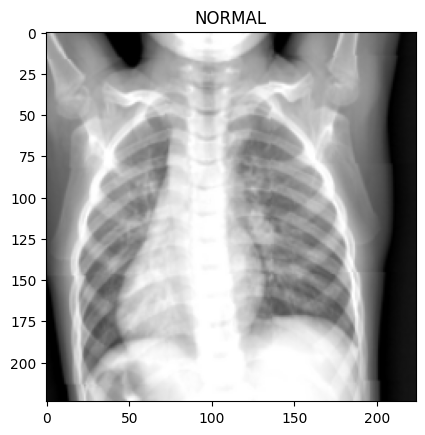

In [170]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

In [171]:
image, label = train_datasets[5000]
print(image) # Ïù¥ÎØ∏ÏßÄ
print(label) # 1
print(train_datasets.classes[label]) # PNEUMONIA

tensor([[[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.

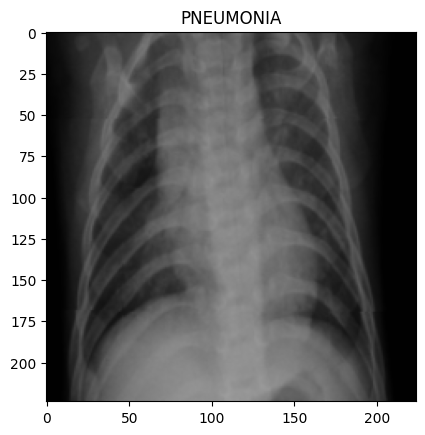

In [172]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

# 2. Îç∞Ïù¥ÌÑ∞ Î∞∞ÏπòÏÇ¨Ïù¥Ï¶àÎ°ú Î∂ÑÎ¶¨ÌïòÍ∏∞

In [173]:
# DataLoader Î•º ÏÇ¨Ïö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÎààÎã§
# batch_size Î™á Í∞úÏî© Í∑∏Î£π ÏßÄÏùÑÏßÄ Ï†ïÌïúÎã§
# shuffle Îç∞Ïù¥ÌÑ∞Î•º ÏàúÏÑúÎåÄÎ°ú ÎÇòÎàÑÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº ÎûúÎç§ÏúºÎ°ú ÏÑûÏñ¥ÏÑú ÏûêÎ•∏Îã§ 
# ‚≠ê‚≠ê ÌïôÏäµÏóê ÏòÅÌñ•ÏùÑ Ï§Ñ Ïàò ÏûàÏúºÎØÄÎ°ú Train Data ÏóêÎäî True Î°ú ÏÑ§Ï†ï ÌïòÏûê!
train_dataLoader = DataLoader(train_datasets, batch_size=32, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=32)
val_dataLoader = DataLoader(val_datasets, batch_size=32) # ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

## Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ÌïòÍ∏∞

tensor([[[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.0373],
         ...,
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]],

        [[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.0373],
         ...,
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]],

        [[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.

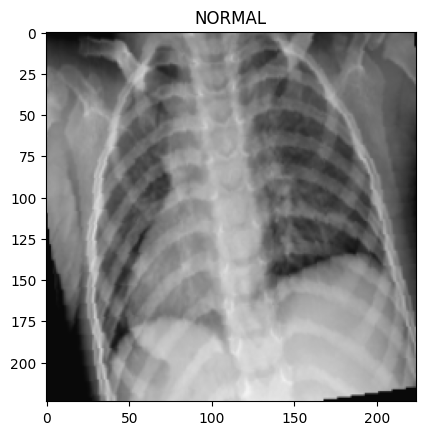

In [174]:
images, labels = next(iter(train_dataLoader)) # ÌäúÌîå (Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÎßåÌÅºÏùò Ïù¥ÎØ∏ÏßÄÎì§, Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÎßåÌÅºÏùò Ï†ïÎãµÎì§)
print(images[0])
print(labels[0])

view_img(images[0], train_datasets.classes[labels[0]], cmap='gray')

## Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú ÌôïÏù∏ÌïòÍ∏∞

In [175]:
# Ï∞®Ïõê Ïàò ÌôïÏù∏ÌïòÍ∏∞
images.dim()

4

In [176]:
# Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÏàòÎßåÌÅº Î∂ÑÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Ïùò ÌòïÌÉú ÌôïÏù∏ÌïòÍ∏∞
# Í∞Å Ï∞®ÏõêÏùò ÏùòÎØ∏: [Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à, Ï±ÑÎÑêÏàò, Ïù¥ÎØ∏ÏßÄ Í∞ÄÎ°ú ÏÇ¨Ïù¥Ï¶à, Ïù¥ÎØ∏ÏßÄ ÏÑ∏Î°ú ÏÇ¨Ïù¥Ï¶à]
images.shape

torch.Size([32, 3, 224, 224])

In [177]:
# Ïù¥ÎØ∏ÏßÄ ÌïúÏû•Ïùò Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú ÌôïÏù∏ÌïòÍ∏∞
images[0].shape

torch.Size([3, 224, 224])

## Ïù¥ÎØ∏ÏßÄ Í∑∏Î¶¨ÎìúÎ°ú ÌôïÏù∏ÌïòÍ∏∞

In [178]:
def view_grid_img(images, title):
    images_data = torchvision.utils.make_grid([image for image in images])

    print(labels)
    view_img(images_data, title)

tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])


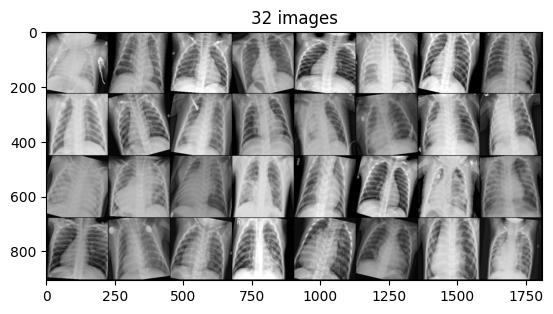

In [179]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataLoader)) # ÌäúÌîå (ÌïúÍ∞úÏùò Î∞∞ÏπòÏóê Îì§Ïñ¥ÏûàÎäî Ïù¥ÎØ∏ÏßÄÎì§, ÌïúÍ∞úÏùò Î∞∞ÏπòÏóê Îì§Ïñ¥ÏûàÎäî Ï†ïÎãµÎì§)
images_data = torchvision.utils.make_grid(images) # Ïù¥ÎØ∏ÏßÄÎ•º Í∑∏Î¶¨ÎìúÎ°ú ÎßåÎì†Îã§

print(labels)
view_img(images_data, '32 images')

# 3. Î™®Îç∏ Ï†ïÏùòÌïòÍ∏∞/Ï§ÄÎπÑÌïòÍ∏∞

## 1) Î™®Îç∏ Í∞ÄÏ†∏Ïò§Í∏∞

In [180]:
# pretrained Îäî deprecated Îê®
# pretrained ÎùºÎäî ÏòµÏÖò, ÌååÎùºÎØ∏ÌÑ∞Í∞Ä Îçî Ïù¥ÏÉÅ ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÎäîÎã§.
# Ïù¥Îäî Í≥≥ ÏóÜÏñ¥ÏßàÏàòÎèÑ ÏûàÎäî ÏúÑÌóòÌïú ÌååÎùºÎØ∏ÌÑ∞Í∞íÏù¥Îã§. > Ïù¥ÌõÑÏóê Ïù¥Î∂ÄÎ∂ÑÏù¥ ÏÇ¨ÎùºÏßà Í∞ÄÎä•ÏÑ± ÏûàÏùå!
model = models.efficientnet_b0(pretrained = True)
model

c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [181]:
from torchvision.models import ResNet34_Weights, EfficientNet_B0_Weights

# y = w1x1 + w2x2 + .... + B
# w1, w2 ÏôÄ Í∞ôÏùÄ ÌöåÍ∏∞Í≥ÑÏàò, Í∞ÄÏ§ëÏπò, ÌååÎùºÎØ∏ÌÑ∞ Í∞íÏùÑ ÏÑ∏Î∂ÄÏ°∞Ï†ïÌï† Ïàò ÏûàÎèÑÎ°ù Î≥ÄÍ≤Ω Îê®

# pretrained = True Î°ú ÏÑ§Ï†ïÌïú Í≤ÉÍ≥º ÎèôÏùºÌïòÍ≤å ÏûëÎèôÌïòÎäî ÏΩîÎìú
model = models.efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 2) ÌååÏù∏ ÌäúÎãùÌïòÍ∏∞

### ÎèôÍ≤∞ÌïòÍ∏∞

In [182]:
for param in model.parameters():
    param.requires_grad = False

### Î∂ÑÎ•òÍ∏∞ ÏàòÏ†ïÌïòÍ∏∞

In [183]:
# Renet34
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [184]:
# EfficientNet_B0
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1000, bias=True)
  )

# 4. Î™®Îç∏ ÌïôÏäµÌïòÍ∏∞

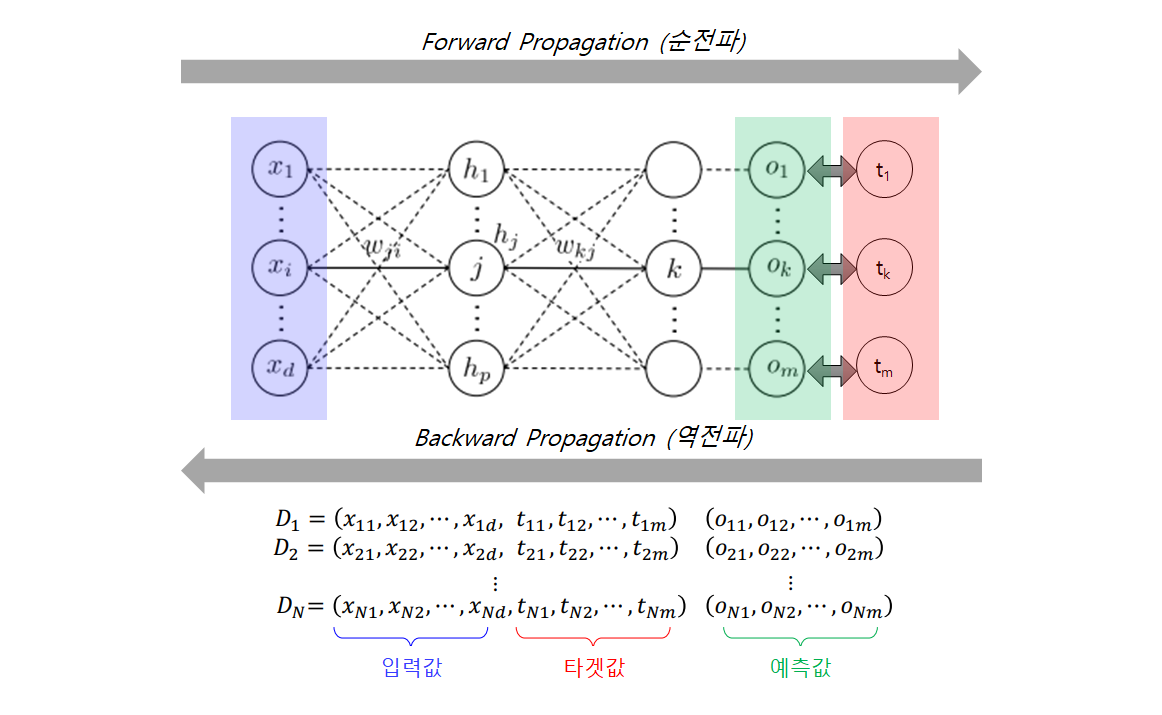

In [196]:
# Î™®Îç∏ ÌïôÏäµ ÌÅ∞ ÌùêÎ¶Ñ
# 1) ÏàúÏ†ÑÌåå
# 2) ÏÜêÏã§Ìï®Ïàò
# 3) Ïó≠Ï†ÑÌåå, ÌååÎùºÎØ∏ÌÑ∞ ÏóÖÎç∞Ïù¥ÌÑ∞

# Î™®Îç∏ÏùÑ gpuÏóê ÎÑ£ÎäîÎã§
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optim = Adam(model.parameters(), lr=1e-3) # ÏµúÏ†ÅÌôî Ìï®Ïàò 0.001 ~ 0.003
criterion = nn.CrossEntropyLoss()         # ÏÜêÏã§Ìï®Ïàò
epochs = 90

from tensorboardX import SummaryWriter
# ÌÖêÏÑúÎ≥¥Îìú ÌôúÏö©ÌïòÏó¨, ÏµúÏ†ÅÌôî Í≥ºÏ†ïÏùÑ ÏãúÍ∞ÅÌôî Ìï©ÎãàÎã§
writer = SummaryWriter()
step = 0

for epoch in range(epochs):
    for images, labels in tqdm.tqdm(train_dataLoader): # (Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÎßåÌÅºÏùò Ïù¥ÎØ∏ÏßÄ , Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÎßåÌÅºÏùò ÎùºÎ≤®)
        optim.zero_grad() # üìå ÏµúÏ†ÅÌôî Ìï®ÏàòÎ•º Ï¥àÍ∏∞Ìôî Ìï¥ÏïºÌï® (Ìïú Î≤à ÌïôÏäµÏãú ÎßàÎã§)
        
        # 1) ÏàúÏ†ÑÌåå
        preds = model(images.to(device))
        
        # 2) ÏÜêÏã§Í≥ÑÏÇ∞
        loss = criterion(preds, labels.to(device))

        # 3) Ïó≠Ï†ÑÌåå
        loss.backward()
        optim.step()

        step += 1 # step = step + 1

    print(f"{epoch + 1} loss : {loss}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:51<00:00,  1.46it/s]


1 loss : 0.11743654310703278


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:46<00:00,  1.53it/s]


2 loss : 0.2508658468723297


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:46<00:00,  1.52it/s]


3 loss : 0.021139662712812424


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:47<00:00,  1.52it/s]


4 loss : 0.11468292027711868


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


5 loss : 0.1432289183139801


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


6 loss : 0.10209421813488007


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


7 loss : 0.12553666532039642


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


8 loss : 0.2735424339771271


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


9 loss : 0.09849358350038528


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


10 loss : 0.015258844941854477


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


11 loss : 0.14427633583545685


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


12 loss : 0.06151322275400162


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


13 loss : 0.07876542210578918


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


14 loss : 0.19355952739715576


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


15 loss : 0.09899871796369553


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


16 loss : 0.11331980675458908


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


17 loss : 0.4177286624908447


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


18 loss : 0.043127864599227905


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


19 loss : 0.21082046627998352


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


20 loss : 0.053442150354385376


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


21 loss : 0.059843871742486954


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


22 loss : 0.13788573443889618


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


23 loss : 0.059474483132362366


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


24 loss : 0.04473792016506195


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


25 loss : 0.03728756308555603


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


26 loss : 0.2514338195323944


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


27 loss : 0.06359788030385971


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


28 loss : 0.08179949969053268


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


29 loss : 0.04241714999079704


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


30 loss : 0.08960267901420593


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


31 loss : 0.048954129219055176


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


32 loss : 0.08048363775014877


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


33 loss : 0.22708135843276978


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


34 loss : 0.15484356880187988


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


35 loss : 0.0951399952173233


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


36 loss : 0.2290814369916916


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


37 loss : 0.046356555074453354


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


38 loss : 0.14890989661216736


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


39 loss : 0.10007448494434357


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


40 loss : 0.042744074016809464


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


41 loss : 0.13656127452850342


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


42 loss : 0.11347499489784241


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


43 loss : 0.1565539538860321


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


44 loss : 0.07069386541843414


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


45 loss : 0.25046226382255554


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


46 loss : 0.3530505895614624


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


47 loss : 0.13308881223201752


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


48 loss : 0.061569105833768845


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


49 loss : 0.053560636937618256


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


50 loss : 0.09095839411020279


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


51 loss : 0.1955648958683014


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


52 loss : 0.0307247806340456


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


53 loss : 0.32605692744255066


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


54 loss : 0.2075575590133667


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


55 loss : 0.2262122929096222


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


56 loss : 0.24853000044822693


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:50<00:00,  1.47it/s]


57 loss : 0.07011909037828445


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


58 loss : 0.047438330948352814


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


59 loss : 0.07340637594461441


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


60 loss : 0.050216998904943466


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


61 loss : 0.21534425020217896


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


62 loss : 0.11409573256969452


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


63 loss : 0.11853261291980743


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


64 loss : 0.06338589638471603


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


65 loss : 0.06865085661411285


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


66 loss : 0.0818362608551979


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


67 loss : 0.12804868817329407


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


68 loss : 0.5086345672607422


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


69 loss : 0.12229108810424805


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


70 loss : 0.04083159193396568


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


71 loss : 0.11867021769285202


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.50it/s]


72 loss : 0.004461456090211868


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


73 loss : 0.09636148065328598


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


74 loss : 0.04063833877444267


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


75 loss : 0.039330605417490005


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


76 loss : 0.024114049971103668


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


77 loss : 0.14408835768699646


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


78 loss : 0.05994086340069771


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


79 loss : 0.0970744863152504


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


80 loss : 0.024737205356359482


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


81 loss : 0.042562637478113174


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


82 loss : 0.24905402958393097


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.51it/s]


83 loss : 0.14986640214920044


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


84 loss : 0.08974821865558624


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


85 loss : 0.09209927171468735


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


86 loss : 0.0692850723862648


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.48it/s]


87 loss : 0.02502204105257988


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:49<00:00,  1.49it/s]


88 loss : 0.13238903880119324


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:48<00:00,  1.50it/s]


89 loss : 0.1606305092573166


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 163/163 [01:47<00:00,  1.51it/s]

90 loss : 0.03121441975235939


üí° Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî(Weight Initialization)Î•º Ìï¥ÏïºÌïòÎäî Ïù¥Ïú†
Î™®Îç∏Ïùò Ï∏µÏù¥ ÍπäÏñ¥ÏßàÏàòÎ°ù,   
ÌôúÏÑ±Ìôî Ìï®Ïàò Ïù¥ÌõÑ Îç∞Ïù¥ÌÑ∞Ïùò Î∂ÑÌè¨Í∞Ä ÌïúÏ™ΩÏúºÎ°ú Ïè†Î¶¥ Ïàò ÏûàÎã§.   
Ïù¥Îü¨Ìïú ÌòÑÏÉÅÏùÄ Ìö®Ïú®Ï†ÅÏù¥Í≥† ÏõêÌôúÌïú Î™®Îç∏ ÌïôÏäµÏùÑ Î∞©Ìï¥ÌïúÎã§.

# 5. Î™®Îç∏ Ï†ÄÏû•ÌïòÍ∏∞

In [197]:
torch.save(model.state_dict(), 'models/efficientNet_b0_state_100_dataTuning.pth')

In [187]:
torch.save(model, 'models/resnet34_model.pth') # Î™®Îç∏ÏùÑ ÌÜµÏúºÎ°ú Ï†ÄÏû•

## Ï†ÄÏû•Ìïú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞

In [6]:
load_model = models.resnet34(pretrained=True)
load_model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
load_model.load_state_dict(torch.load('models/resnet34_state.pth', map_location=device))
load_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 6. Î™®Îç∏ ÌèâÍ∞Ä

f1 Ïä§ÏΩîÏñ¥Î°ú ÌèâÍ∞ÄÌïúÎã§

## ÌÖåÏä§Ìä∏ÌïòÍ∏∞

In [ ]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

# F1 Í∞ùÏ≤¥ Ï†ïÏùò (GPU Ïì∞Î©¥ .to(device))
f1_metric = BinaryF1Score().to(device)

# f1_binary = BinaryF1Score() # Î∂ÑÎ•òÌï† ÌÅ¥ÎûòÏä§Í∞Ä 2Í∞úÏù¥ÎØÄÎ°ú BinaryF1Score ÏÇ¨Ïö©
# score = f1_binary(preds, labels)

# Î©ÄÌã∞ÌÅ¥ÎûòÏä§ : Î∂ÑÎ•òÌï† ÌÅ¥ÎûòÏä§Í∞Ä 2Í∞ú Ïù¥ÏÉÅÏùº Í≤ΩÏö∞ MulticlassF1Score ÏÇ¨Ïö©
# f1_macro = MulticlassF1Score(num_classes=10, average="macro")
# score = f1_macro(preds, target)

model.eval() # üìå Î™®Îç∏ÏùÑ Ï∂îÎ°†Ïö©ÏúºÎ°ú Ï†ÑÌôòÌïòÍ≤å ÌïòÎäî ÏΩîÎìú

with torch.no_grad(): # ÌèâÍ∞Ä Îã®Í≥ÑÏù¥ÎØÄÎ°ú Î™®Îç∏Ïù¥ ÎçîÏù¥ÏÉÅ ÌïôÏäµÌïòÏßÄ ÏïäÎèÑÎ°ù ÎßâÎäî ÏΩîÎìú
    for images, labels in test_dataLoader:

        preds = model(images.to(device)) # [[0Ïùº ÌôïÎ•†, 1Ïùº ÌôïÎ•†]]
        
        _, preds = torch.max(preds.data, dim=1) # 0, 1 Ï§ë ÌôïÎ•†Ïù¥ Îçî ÎÜíÏùÄ Ï™ΩÏùò Ïù∏Îç±Ïä§Î•º Î∞òÌôòÌïòÏó¨ ÏòàÏ∏°
        f1_metric.update(preds, labels.to(device))

# f1 Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.9202454090118408


## ÌèâÍ∞ÄÌïòÍ∏∞

ÌèâÍ∞ÄÎäî val Îç∞Ïù¥ÌÑ∞Î°ú ÏßÑÌñâÌï©ÎãàÎã§

In [199]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

model.eval() # üìå Î™®Îç∏ÏùÑ Ï∂îÎ°†Ïö©ÏúºÎ°ú Ï†ÑÌôòÌïòÍ≤å ÌïòÎäî ÏΩîÎìú

with torch.no_grad(): # ÌèâÍ∞Ä Îã®Í≥ÑÏù¥ÎØÄÎ°ú Î™®Îç∏Ïù¥ ÎçîÏù¥ÏÉÅ ÌïôÏäµÌïòÏßÄ ÏïäÎèÑÎ°ù ÎßâÎäî ÏΩîÎìú
    for images, labels in val_dataLoader: # ÌÖåÏä§Ìä∏ÏôÄÎäî ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÎäî Î∂ÄÎ∂ÑÎßå Îã§Î•¥Îã§

        preds = model(images.to(device))

        _, preds = torch.max(preds.data, dim=1)
        f1_metric.update(preds, labels.to(device))

f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.9217810034751892
